In [1]:
%load_ext autoreload
%autoreload 2

# Loading Classes For Model and Dataset

In [2]:
%run Model.ipynb

In [3]:
%run NimbroDataLoader-RGB.ipynb

In [4]:
%run NimbroSegmentDataLoader.ipynb

In [5]:
%run NimbroDataLoader-RGB-YAML.ipynb

# Loading Blob Dataset

In [6]:
dataset1 = NimbroDataset('data/bigcuda5.informatik.uni-bonn.de:8686/blob/forceTest/',image_size=(HEIGHT,WIDTH))

dataset2 = NimbroDataset('data/bigcuda5.informatik.uni-bonn.de:8686/blob/forceTrain/',image_size=(HEIGHT,WIDTH))

dataset3 = NimbroDataset('data/bigcuda5.informatik.uni-bonn.de:8686/blob/dataset/',image_size=(HEIGHT,WIDTH))

# Adding Extra Tagged Data

In [7]:
train_new1 = NimbroDataset_YAML('Tagged Data/160','Tagged Data/160/export_bitbots-2018-iran-01_2072.txt',(HEIGHT,WIDTH))

train_new2 = NimbroDataset_YAML('Tagged Data/161','Tagged Data/161/export_bitbots-2018-iran-02_2073.txt',(HEIGHT,WIDTH))

train_new3 = NimbroDataset_YAML('Tagged Data/162','Tagged Data/162/export_bitbots-2018-iran-03_2074.txt',(HEIGHT,WIDTH))

# Adding Manually Tagged Data

In [8]:
test_dataset = NimbroDataset('RosData/',image_size=(HEIGHT,WIDTH))

In [9]:
batch_size = 16

In [10]:
train_dataset = ConcatDataset([dataset1,dataset2,dataset3,train_new1,train_new2,train_new3])
len(train_dataset)

10155

## Sample Dataset from Blobs

In [11]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

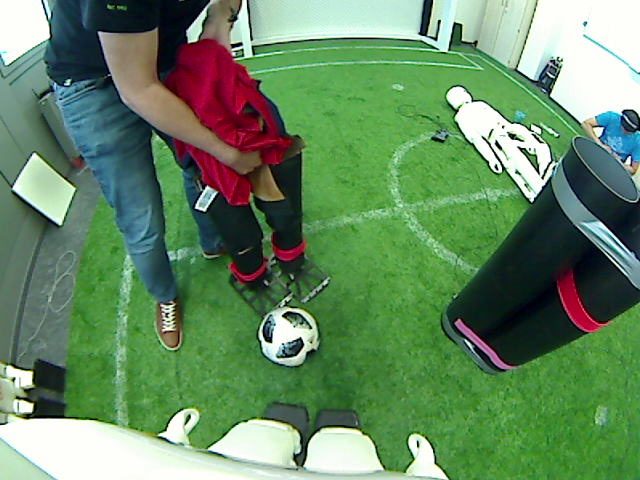

In [12]:
TF.to_pil_image(invTrans(dataset1[1][0]))

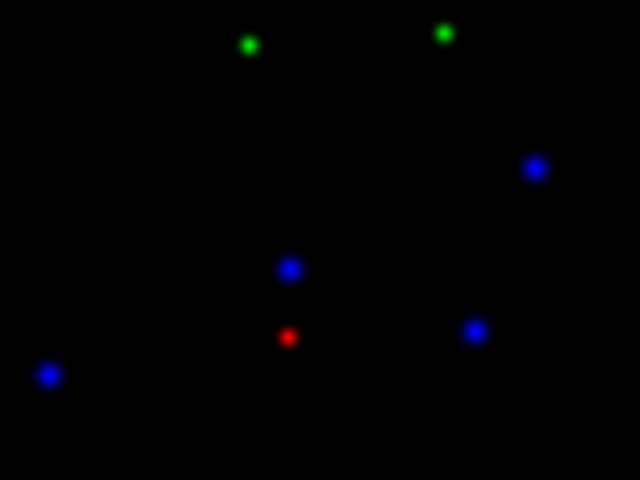

In [13]:
TF.resize(TF.to_pil_image(dataset1[1][1]),(480,640))

In [14]:
train_blob_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                               batch_size=batch_size, 
                               shuffle=True)
val_blob_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                               batch_size=batch_size, 
                               shuffle=False)

# Loading Segmentation Dataset

In [15]:
dataset_seg_1 = NimbroSegmentDataset('data/bigcuda5.informatik.uni-bonn.de:8686/segmentation/forceTrain/',(HEIGHT,WIDTH))
dataset_seg_2 = NimbroSegmentDataset('data/bigcuda5.informatik.uni-bonn.de:8686/segmentation/dataset/',(HEIGHT,WIDTH))

dataset_seg = ConcatDataset([dataset_seg_1,dataset_seg_2])
len(dataset_seg)

1192

## Sample from Segmentation

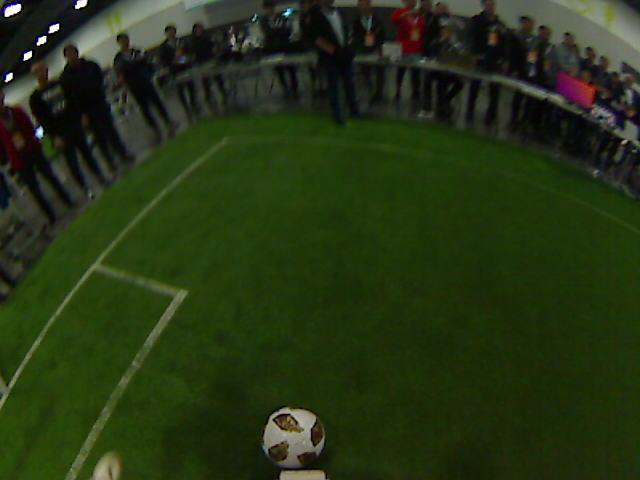

In [16]:
TF.to_pil_image(invTrans(dataset_seg_1[50][0]))

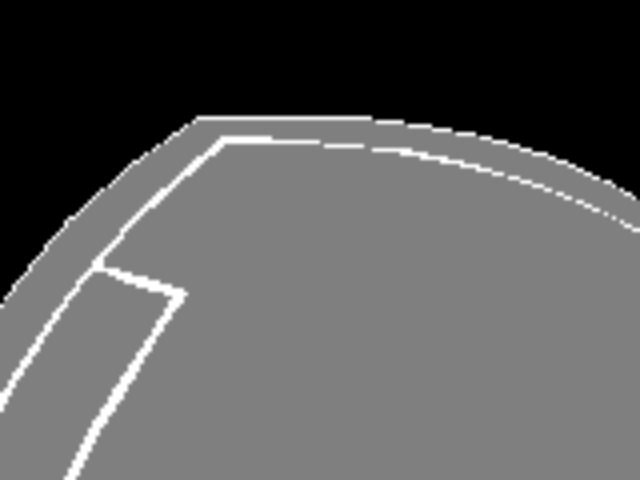

In [17]:
TF.resize(TF.to_pil_image(dataset_seg_1[50][1]/2),(480,640))

## Batching and loading segmentation dataset

In [18]:
train_seg_dataset, test_seg_dataset = torch.utils.data.random_split(dataset_seg, [1050,len(dataset_seg)-1050])
train_seg_loader = torch.utils.data.DataLoader(dataset=train_seg_dataset, 
                               batch_size=batch_size, 
                               shuffle=True)

In [19]:
val_seg_loader = torch.utils.data.DataLoader(dataset=test_seg_dataset, 
                               batch_size=batch_size, 
                               shuffle=False)

# Optimiser and Network objects

In [319]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True

In [320]:
n_epochs = 100
n_batchs = 100
# train_blob_every = 3
lr = 0.001
nimbro_net = NimbroNet18()
optimizer = torch.optim.Adam(nimbro_net.parameters(), lr=lr, betas=(0.5, 0.999))

In [321]:
nimbro_net.cuda()

NimbroNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

# Loss function for training

In [322]:
criterion_cross_ent = nn.CrossEntropyLoss()

def mse_loss_fn(y_hat,y):
    return ((y - y_hat)**2).sum()/y.shape[0]

def total_variation_loss(y):
    return (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))/y.shape[0]

In [323]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/nimbro_experiment_6')

In [324]:
train_losses = []
val_losses = []
iter_ = 0

# Training Loop

In [ ]:
iter_blob = iter_

In [675]:
nimbro_net.train()
var_loss_blob_weight = 0.000002
var_loss_seg_weight = 0.000003
mse_loss_weight = 1


for epoch in range(n_epochs*2,n_epochs*3):
    for batch_id in range(n_batchs):

        #######################
        #  USE GPU FOR MODEL  #
        #######################
    

        if batch_id % 10 == 0:
            images, target = next(iter(train_blob_loader))
            if torch.cuda.is_available():
                images = images.cuda()
                target = target.cuda()

            optimizer.zero_grad()
            _,blob = nimbro_net(images)

            ttl_var_blob = total_variation_loss(blob)*var_loss_blob_weight
            mse_loss = mse_loss_fn(blob, target)*mse_loss_weight
            blob_loss = ttl_var_blob + mse_loss
            blob_loss.backward()
            nn.utils.clip_grad_norm_(nimbro_net.parameters(),1)
            optimizer.step()
            writer.add_scalar('Train MSE', mse_loss.item(),global_step=iter_blob)
            writer.add_scalar('Train Variance Loss(Blobs)',ttl_var_blob.item(),iter_blob)
            iter_blob += 1
            
        images, target_seg = next(iter(train_seg_loader))  
        if torch.cuda.is_available():
            images = images.cuda()
            target_seg = target_seg.cuda()
            
        optimizer.zero_grad()
        seg,_ = nimbro_net(images)
        
        ttl_var_seg = total_variation_loss(seg[:,[0,1],:,:])*var_loss_seg_weight
        cross_loss = criterion_cross_ent(seg,target_seg.long())
        seg_loss = cross_loss + ttl_var_seg
        seg_loss.backward()
        nn.utils.clip_grad_norm_(nimbro_net.parameters(),1)
        optimizer.step()

        train_losses.append((mse_loss.item(),ttl_var_blob.item(),cross_loss.item(),ttl_var_seg.item()))
#         writer.add_scalar('Train MSE', mse_loss.item(),global_step=iter_)
        writer.add_scalar('Train Cross Entropy',cross_loss.item(),iter_)
#         writer.add_scalar('Train Variance Loss(Blobs)',ttl_var_blob.item(),iter_)
        writer.add_scalar('Train Variance Loss(Segmentation)',ttl_var_seg.item(),iter_)
        iter_ += 1
        writer.flush()
        
    print(f'Epoch:{epoch} Train MSE: {mse_loss.item():.3f}\t\tCross Entropy: {cross_loss.item():.3f}')
    print(f'\tVariance Loss Blobs:{ttl_var_blob.item():.2}\tVariance Loss Seg:{ttl_var_seg.item():.3}')

    
    nimbro_net.eval()
    with torch.no_grad():
        mse_loss = 0
        seg_loss = 0
        tot_var_loss_blob = 0
        tot_var_loss_seg = 0

        for k,(images, target) in enumerate(val_blob_loader):
            #######################
            #  USE GPU FOR MODEL  #
            #######################
            if torch.cuda.is_available():
                images = images.cuda()
                target = target.cuda()

            # Forward pass only to get logits/output
            _,blob = nimbro_net(images)
            mse_loss +=   (mse_loss_fn(blob,target).item()-mse_loss)/(k+1)
            tot_var_loss_blob += (total_variation_loss(blob) - tot_var_loss_blob)/(k+1)

        for k,(images, target) in enumerate(val_seg_loader):
            #######################
            #  USE GPU FOR MODEL  #
            #######################
            if torch.cuda.is_available():
                images = images.cuda()
                target = target.cuda()

            # Forward pass only to get logits/output
            seg,_ = nimbro_net(images)
            seg_loss +=   (criterion_cross_ent(seg,target.long()).item()-seg_loss)/(k+1)
            tot_var_loss_seg += (total_variation_loss(seg[:,[0,1],:,:]) - tot_var_loss_seg)/(k+1)
        
    # Print Loss
    tot_var_loss_blob *= var_loss_blob_weight
    tot_var_loss_seg  *= var_loss_seg_weight
    mse_loss *= mse_loss_weight
    
    writer.add_scalar('Validation MSE', mse_loss,epoch)
    writer.add_scalar('Validation Cross Entropy',seg_loss,epoch)
    writer.add_scalar('Validation Variance Loss(Blobs)',tot_var_loss_blob.item(),epoch)
    writer.add_scalar('Validation Variance Loss(Segmentation)',tot_var_loss_seg.item(),epoch)
    writer.flush()
    print(f'\tValidation MSE Loss: {mse_loss:.3f}\tCross Entropy: {seg_loss:.3f}')
    print(f'\tVariance Loss Blobs:{tot_var_loss_blob:.3}\tVariance Loss Seg:{tot_var_loss_seg:.2}\n--------------------------------------------------------------\n')
    val_losses.append((mse_loss,tot_var_loss_blob.item(),seg_loss,tot_var_loss_seg.item()))
    nimbro_net.train()

Epoch:200 Train MSE: 10.897		Cross Entropy: 0.097
	Variance Loss Blobs:0.00045	Variance Loss Seg:0.0258
	Validation MSE Loss: 20.375	Cross Entropy: 0.087
	Variance Loss Blobs:0.000466	Variance Loss Seg:0.024
--------------------------------------------------------------

Epoch:201 Train MSE: 10.716		Cross Entropy: 0.068
	Variance Loss Blobs:0.00045	Variance Loss Seg:0.0226
	Validation MSE Loss: 20.157	Cross Entropy: 0.088
	Variance Loss Blobs:0.000486	Variance Loss Seg:0.023
--------------------------------------------------------------

Epoch:202 Train MSE: 11.651		Cross Entropy: 0.083
	Variance Loss Blobs:0.00046	Variance Loss Seg:0.0245
	Validation MSE Loss: 20.256	Cross Entropy: 0.085
	Variance Loss Blobs:0.00046	Variance Loss Seg:0.024
--------------------------------------------------------------

Epoch:203 Train MSE: 16.201		Cross Entropy: 0.086
	Variance Loss Blobs:0.00044	Variance Loss Seg:0.0236
	Validation MSE Loss: 19.985	Cross Entropy: 0.085
	Variance Loss Blobs:0.00046	Va

	Validation MSE Loss: 20.624	Cross Entropy: 0.077
	Variance Loss Blobs:0.00051	Variance Loss Seg:0.02
--------------------------------------------------------------

Epoch:231 Train MSE: 12.136		Cross Entropy: 0.057
	Variance Loss Blobs:0.00053	Variance Loss Seg:0.0195
	Validation MSE Loss: 20.887	Cross Entropy: 0.080
	Variance Loss Blobs:0.000512	Variance Loss Seg:0.019
--------------------------------------------------------------

Epoch:232 Train MSE: 11.170		Cross Entropy: 0.069
	Variance Loss Blobs:0.00052	Variance Loss Seg:0.02
	Validation MSE Loss: 20.704	Cross Entropy: 0.085
	Variance Loss Blobs:0.000526	Variance Loss Seg:0.019
--------------------------------------------------------------

Epoch:233 Train MSE: 11.948		Cross Entropy: 0.051
	Variance Loss Blobs:0.00056	Variance Loss Seg:0.0174
	Validation MSE Loss: 21.004	Cross Entropy: 0.080
	Variance Loss Blobs:0.000553	Variance Loss Seg:0.019
--------------------------------------------------------------

Epoch:234 Train MSE:

KeyboardInterrupt: 

In [676]:
iter_

24923

# Sample Result from Segmentation Test Set

In [677]:
nimbro_net.eval()
i=12
ds = test_seg_dataset

## Input Image (un-normailised)

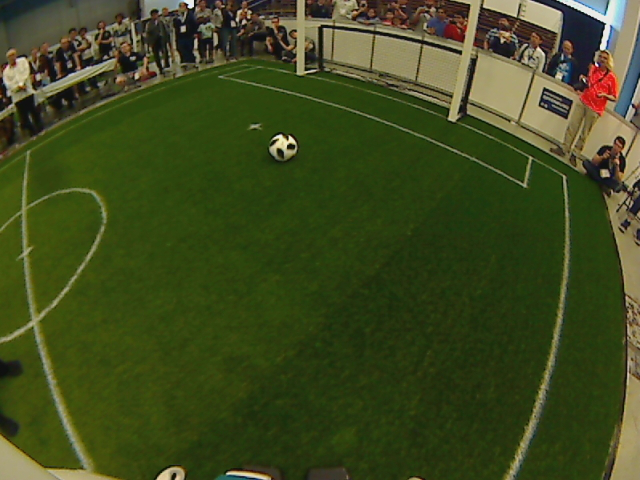

In [678]:
TF.to_pil_image(invTrans(ds[i][0]))

## Expected Segmentation output

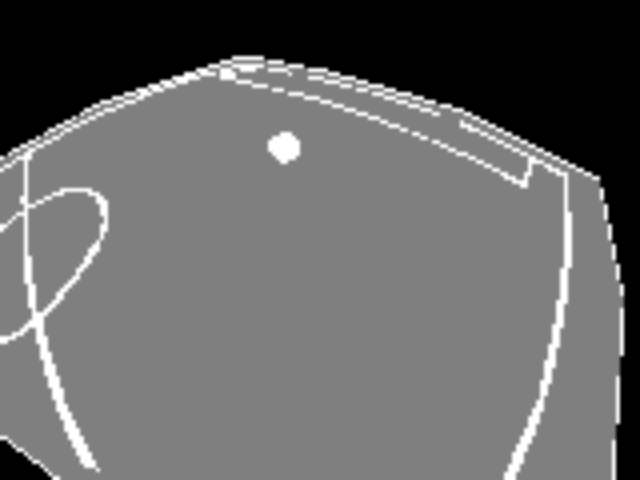

In [679]:
TF.resize(TF.to_pil_image(ds[i][1]/2),(480,640))

## Output Produced

In [680]:
seg,blob = nimbro_net(ds[i][0].unsqueeze(0).cuda())

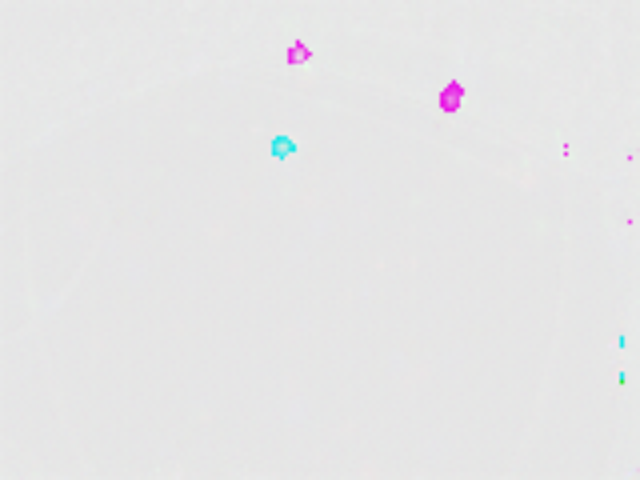

In [682]:
TF.resize(TF.to_pil_image(blob.cpu()[0]-0.1),(480,640))

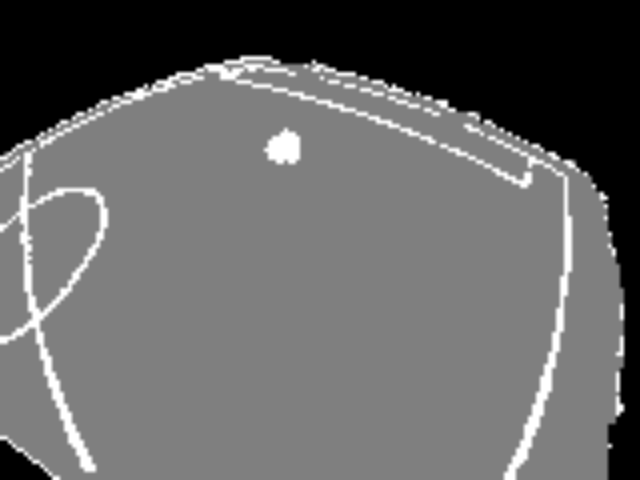

In [683]:
TF.resize(TF.to_pil_image(seg.cpu()[0].argmax(0)/2.0),(480,640))

## Robot Detection

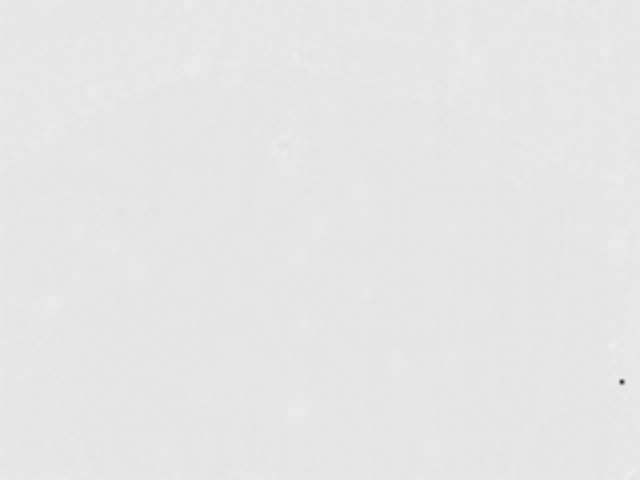

In [684]:
TF.resize(TF.to_pil_image((blob.cpu()[0,2] - 0.1)),(480,640)) # after threshholdi

tensor(0.1117, grad_fn=<MaxBackward1>)


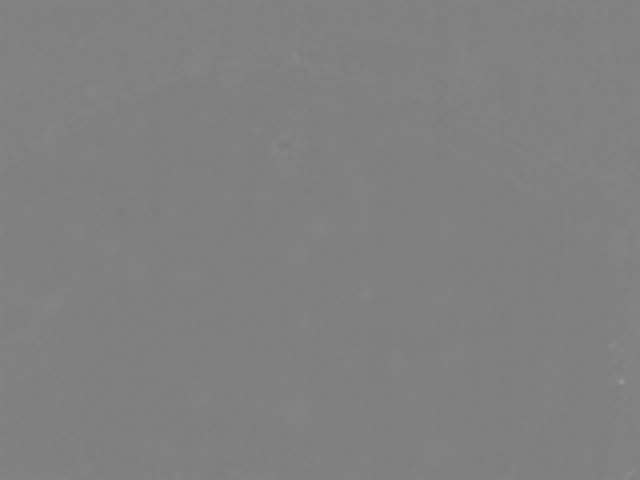

In [685]:
print((blob.cpu()[0,2]).max())
TF.resize(TF.to_pil_image((blob.cpu()[0,2]-0.5)),(480,640)) # after threshholdi

## Goal Post Detection

tensor(0.9875, grad_fn=<MaxBackward1>)


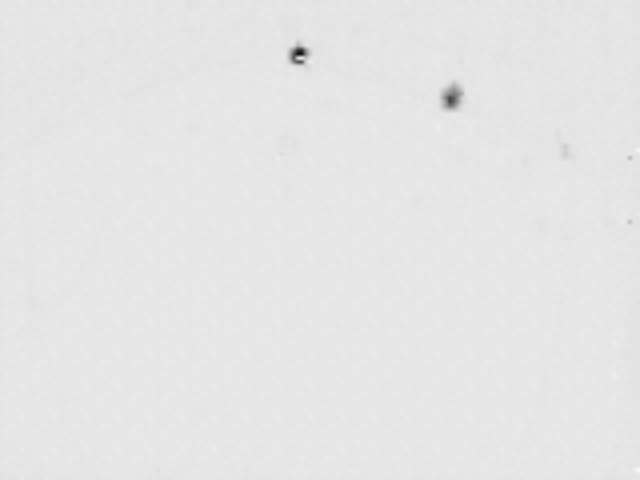

In [686]:
print((blob.cpu()[0,1]).max())
TF.resize(TF.to_pil_image(1-(blob.cpu()[0,1]) - 0.1),(480,640)) # after threshholdin

## Ball Detection

tensor(0.9044, grad_fn=<MaxBackward1>)


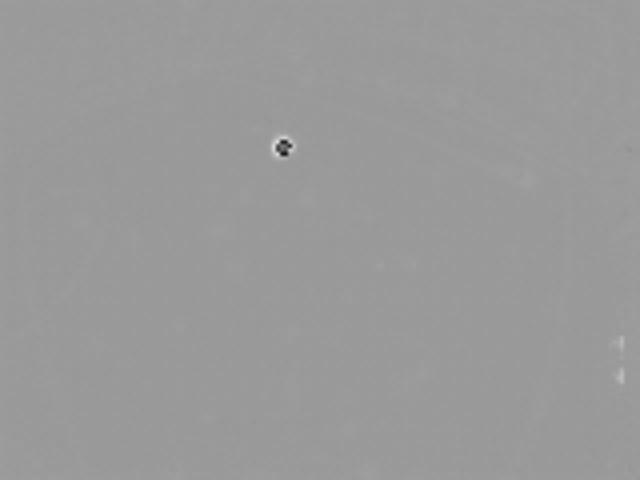

In [687]:
print((blob.cpu()[0,0]).max())
TF.resize(TF.to_pil_image((blob.cpu()[0,0]-0.4)),(480,640)) # after threshholdin

In [688]:
torch.save(nimbro_net.state_dict(), './model5-17Mar')

# Loss Visualisation

In [689]:
import seaborn as sns
from matplotlib import pyplot as plt


In [690]:
mse_val_loss = [loss[0] for loss in val_losses]
var_blob = [loss[1] for loss in val_losses]
nll = [loss[2] for loss in val_losses]
var_seg = [loss[3] for loss in val_losses]

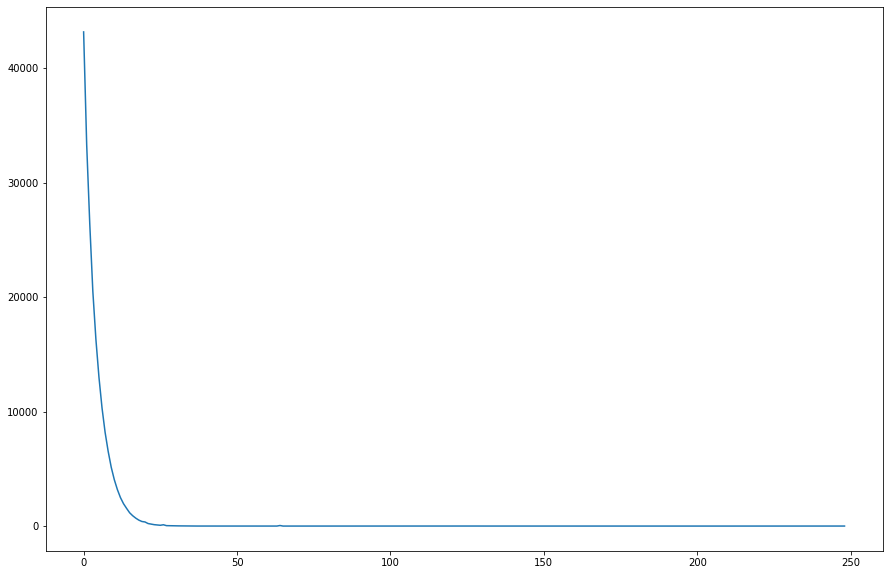

In [691]:
plt.figure(figsize=(15,10))
sns.lineplot(data=np.array(mse_val_loss[:]))
plt.show()

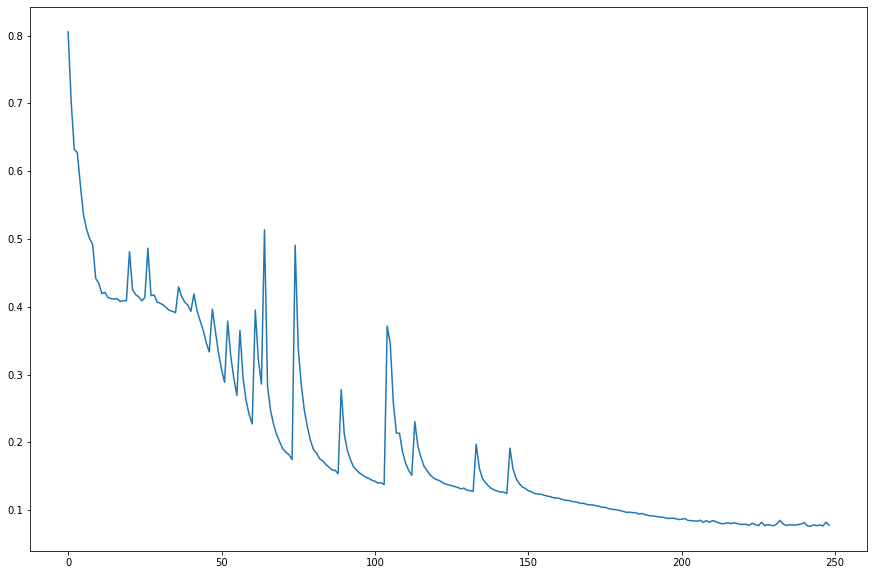

In [692]:
plt.figure(figsize=(15,10))
sns.lineplot(data=np.array(nll))
plt.show()

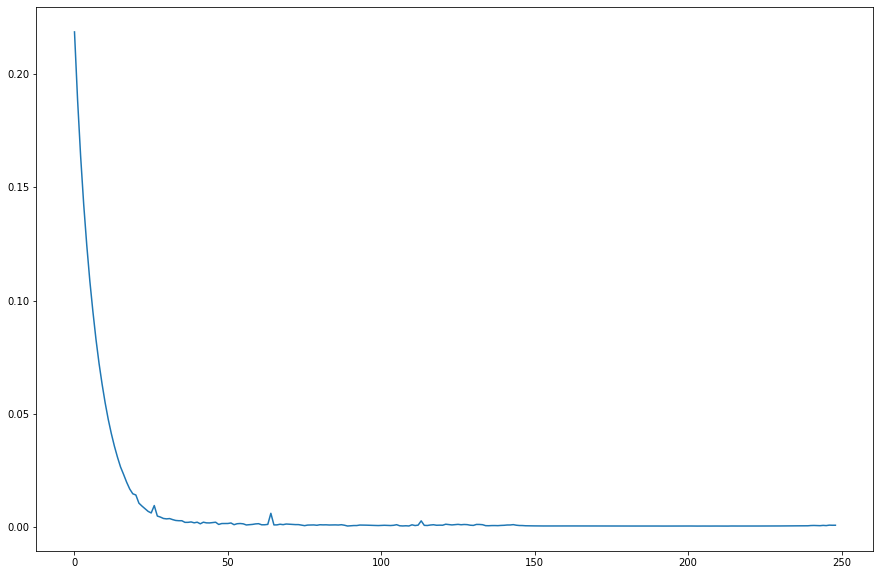

In [693]:
plt.figure(figsize=(15,10))
sns.lineplot(data=np.array(var_blob[:]))
plt.show()

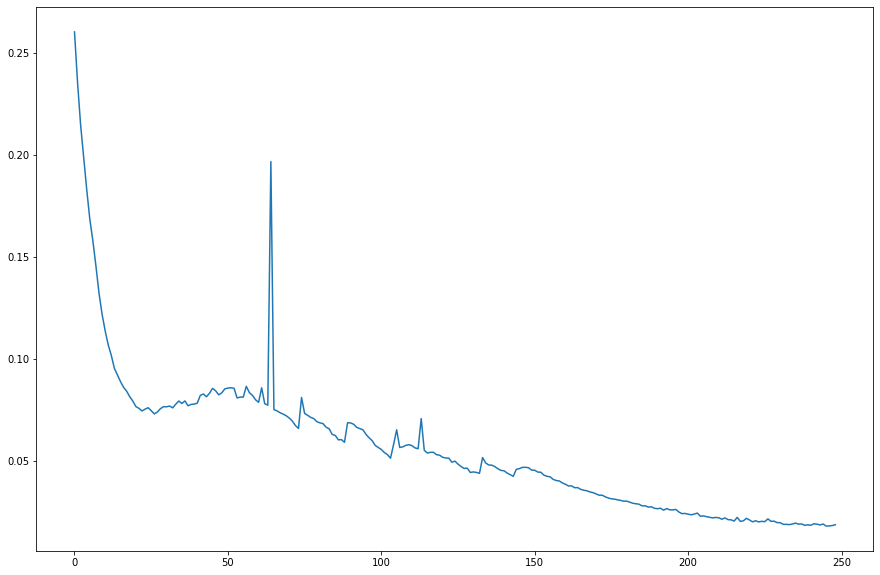

In [694]:
plt.figure(figsize=(15,10))
sns.lineplot(data=np.array(var_seg))
plt.show()

# Accuracy and IoU on Segmentation Head

In [695]:
nimbro_net.eval()
# storing counts for true count, correct count and predicted count
class_accuracy = {'Background':[0,0,0],'Field':[0,0,0],'Line':[0,0,0]}
for k,(images, target) in enumerate(val_seg_loader):

    images = images.cuda()

    seg,_ = nimbro_net(images)
    seg_classes = seg.cpu().argmax(1)
    
    for label,class_ in enumerate(class_accuracy):
        class_accuracy[class_][0] += (target == label).sum().item()
        class_accuracy[class_][1] += ((target == label) & (seg_classes == label) ) .sum().item()
        class_accuracy[class_][2] += (seg_classes == label).sum().item()

In [696]:
class_accuracy

{'Background': [873910, 857484, 875758],
 'Field': [1722001, 1694467, 1726800],
 'Line': [130489, 102093, 123842]}

In [697]:
iou_sum = 0
accuracy_sum = 0
for label,val in class_accuracy.items():
    print(f'{label}    \tAccuracy:{val[1]/val[0]:.3f},   \tIoU:{val[1]/(val[0]+val[2]-val[1]):.3f}')
    accuracy_sum += val[1]/val[0]
    iou_sum += val[1]/(val[0]+val[2]-val[1])

Background    	Accuracy:0.981,   	IoU:0.961
Field    	Accuracy:0.984,   	IoU:0.966
Line    	Accuracy:0.782,   	IoU:0.671


In [698]:
print(f'Average Accuracy {accuracy_sum/3:.3f}, Average IoU:{iou_sum/3:.3f}')

Average Accuracy 0.916, Average IoU:0.866


# Accuracy, Precision, Recall and other mertrics on Detection Head

In [699]:
def get_modes(matrix,pixel_range=5,threshold_prob=0.1,threshold_sum=3.5):
    points = []
    max_val = matrix.max()
    while max_val > threshold_prob:
        i,j = np.unravel_index(matrix.argmax(),matrix.shape)
        if matrix[max(-pixel_range+i,0):min(pixel_range+i,matrix.shape[0]-1),max(-pixel_range+j,0):min(pixel_range+j,matrix.shape[1]-1)].sum().item() > threshold_sum:
            points.append((i,j))
        matrix[max(-pixel_range+i,0):min(pixel_range+i,matrix.shape[0]),max(-pixel_range+j,0):min(pixel_range+j,matrix.shape[1])] = 0
        max_val = matrix.max()
    return points

In [700]:
nimbro_net.eval()
true = [0,0,0]
correct = [0,0,0]
pred = [0,0,0]
pixel_dist = [5,5,10]
for i in range(len(test_dataset)):
    
    seg,blob = nimbro_net(test_dataset[i][0].unsqueeze(0).cuda())
    target = test_dataset[i][1]
    for channel in range(3):
        true_dets = get_modes(target.numpy().copy()[channel],pixel_range=pixel_dist[channel],threshold_prob=0.6,threshold_sum=4)
        pred_dets = get_modes(blob[0,channel].cpu(),pixel_range=pixel_dist[channel])
        true[channel] = true[channel] + len(true_dets)
        pred[channel] = pred[channel] +  len(pred_dets)
#         if channel == 2:
#             print(true_dets,pred_dets,i)
        for p_det in pred_dets:
            for det in true_dets:
                if abs(det[0]-p_det[0]) <= 10 and abs(det[1]-p_det[1]) <=10:
                    correct[channel] = correct[channel] + 1
                    break
        
#         if channel == 2:
#             print(f'correct = {correct[2]} pred = {pred[2]} true = {true[2]}')
    

In [701]:
channel_to_label={0:'Ball', 1:'Goal Post', 2:'Robot'}

In [702]:
true

[355, 597, 229]

In [703]:
correct

[347, 507, 196]

In [704]:
pred

[347, 518, 228]

In [705]:
for channel,label in channel_to_label.items():
    print(f'{label}    \tAccuracy:{correct[channel]/true[channel]:.2f}')
    precision = correct[channel]/pred[channel]
    print(f'\t\tPrecision:{precision:.2f}')
    recall = correct[channel]/(correct[channel]+abs(true[channel]-pred[channel]))
    print(f'\t\tRecall:{recall:.2f}')
    print(f'\t\tF1 Score:{2*precision*recall/(precision+recall):.2f}')
    print(f'\t\tFDR:{1-precision:.2f}')
    print('------------------------------------------')


Ball    	Accuracy:0.98
		Precision:1.00
		Recall:0.98
		F1 Score:0.99
		FDR:0.00
------------------------------------------
Goal Post    	Accuracy:0.85
		Precision:0.98
		Recall:0.87
		F1 Score:0.92
		FDR:0.02
------------------------------------------
Robot    	Accuracy:0.86
		Precision:0.86
		Recall:0.99
		F1 Score:0.92
		FDR:0.14
------------------------------------------
